<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_gradient_descent_M50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
!wget -qO ratings_M50.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWqG6YIAGfpLihYVvtpMeRQB1ngfhPZPydHCoUL87QR3yA?download=1
!wget -qO ratings_M1000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESYy4ukVKs9DkY6-YVBh-0kBr5uQE29dC1Tq0PRi_tJJhg?download=1

In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 4)

In [15]:
# read dataset into dataframe

df = (pd.read_csv('ratings_M50.csv')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 111 num_movie: 50


,user,movie,rating,target
0,0,0,4,0.666667
1,1,0,3,0.500000
...,...,...,...,...
1616,97,49,2,0.333333
1617,103,49,3,0.500000


In [16]:
# split data into train and test sets

split = 0.8
train = df.sample(frac=split)
test  = df[~df.index.isin(train.index)]

display(train)
display(test)

,user,movie,rating,target
142,38,5,1,0.166667
234,57,8,2,0.333333
...,...,...,...,...
32,6,1,1,0.166667
996,102,29,5,0.833333


,user,movie,rating,target
1,1,0,3,0.500000
4,4,0,4,0.666667
...,...,...,...,...
1609,81,49,3,0.500000
1617,103,49,3,0.500000


In [17]:
# build the matrix-multiplication-based model

class UV(nn.Module):
    def __init__(self, N, M, D):                # N: num_user, M: num_movie, D: embedding dimension
        super().__init__()
        self.U = nn.Embedding(N, D)             # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(M, D)             # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, u_idx, m_idx):
        U = self.U(u_idx)                       # retrieve user embeddings by user indexes
        V = self.V(m_idx)                       # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)         # predicted ratings are their dot products
        output = torch.sigmoid(dot_products)    # map to [0,1]
        return output

In [18]:
###
# training
###

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1_000_000
max_epoch = 10_000
patience = 10       # early stop if not improving in this num of evaluations

# initialize model and ...
model = UV(N, M, D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# convert data to torch Tensor
train_u_idx = torch.IntTensor  (train.user.values).to(device)
train_v_idx = torch.IntTensor  (train.movie.values).to(device)
train_y     = torch.FloatTensor(train.target.values).to(device)
train_size  = len(train_u_idx)

test_u_idx  = torch.IntTensor  (test.user.values).to(device)
test_v_idx  = torch.IntTensor  (test.movie.values).to(device)
test_y      = torch.FloatTensor(test.target.values).to(device)

# train
recs = []
min_test_loss = None
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    optimizer.zero_grad()

    batch_idx = torch.randperm(train_size)[:batch_size]
    train_y_hat = model(train_u_idx[batch_idx], train_v_idx[batch_idx])
    loss = loss_fn(train_y_hat, train_y[batch_idx])
    loss.backward()
    optimizer.step()

    # evaluate test loss
    if epoch % 100 == 0:
        model.eval()
        test_y_hat = model(test_u_idx, test_v_idx)
        test_loss = loss_fn(test_y_hat, test_y).item()
        rec = {
            'epoch'     : epoch,
            'train_loss': loss.item(),
            'test_loss' : test_loss,
        }
        recs.append(rec)
        print(rec)

        # check for early stopping
        if min_test_loss is None or test_loss < min_test_loss:
            min_test_loss = test_loss
            not_improving_count = 0
        else:
            not_improving_count += 1
            if not_improving_count >= patience:
                break

{'epoch': 0, 'train_loss': 0.20054535567760468, 'test_loss': 0.18026044964790344}
{'epoch': 100, 'train_loss': 0.16609296202659607, 'test_loss': 0.17566202580928802}
{'epoch': 200, 'train_loss': 0.13363687694072723, 'test_loss': 0.1714055985212326}
{'epoch': 300, 'train_loss': 0.10743825882673264, 'test_loss': 0.16564710438251495}
{'epoch': 400, 'train_loss': 0.08719558268785477, 'test_loss': 0.15866458415985107}
{'epoch': 500, 'train_loss': 0.07110768556594849, 'test_loss': 0.15238048136234283}
{'epoch': 600, 'train_loss': 0.05833229795098305, 'test_loss': 0.1472206562757492}
{'epoch': 700, 'train_loss': 0.04842786863446236, 'test_loss': 0.14090776443481445}
{'epoch': 800, 'train_loss': 0.040674153715372086, 'test_loss': 0.13426323235034943}
{'epoch': 900, 'train_loss': 0.0343940332531929, 'test_loss': 0.12873518466949463}
{'epoch': 1000, 'train_loss': 0.02918178401887417, 'test_loss': 0.12391010671854019}
{'epoch': 1100, 'train_loss': 0.025111962109804153, 'test_loss': 0.119946375489

<Axes: xlabel='epoch'>

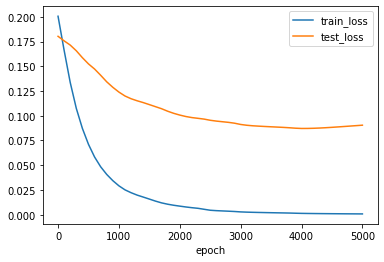

In [19]:
# training curves
pd.DataFrame(recs).set_index('epoch')[['train_loss', 'test_loss']].plot()

In [20]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[-0.1633, -1.7614, -1.1647, -0.0634, -0.8166, -0.3999,  1.2218,  0.0389,
          1.6198,  0.7118],
        [-0.4923, -0.2936,  0.3559, -0.1625,  0.6584, -0.9459, -0.2359, -0.2345,
         -0.4423, -0.1169],
        [ 0.1851, -1.2062, -0.9731,  0.4232, -0.5702, -1.2129,  0.3248,  1.6766,
          0.6049,  0.5652]], device='cuda:0', grad_fn=<SliceBackward0>)
V: tensor([[-1.0493, -0.0342,  1.0855, -0.5514, -0.8943, -0.4853, -0.2801, -0.2339,
          1.0588, -0.8560],
        [ 0.3533,  0.4359, -0.9024,  0.5863,  0.4574,  0.5745,  0.1273,  0.0780,
          2.3077, -1.0755],
        [ 0.5020,  0.0966, -0.5235, -0.5545,  1.4784,  0.1854,  0.1957, -0.0121,
          1.0108, -0.6067]], device='cuda:0', grad_fn=<SliceBackward0>)


In [21]:
# prediction results

test_y_hat = model(test_u_idx, test_v_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
1281,29,42,1,0.166667,0.182238,1.093428,-0.093428
1259,61,40,1,0.166667,0.161214,1.000000,0.000000
912,3,29,5,0.833333,0.557588,3.345528,1.654472
37,28,1,4,0.666667,0.690315,4.141888,-0.141888
1077,29,32,1,0.166667,0.027881,1.000000,0.000000
1580,10,49,3,0.500000,0.100662,1.000000,2.000000
687,67,24,4,0.666667,0.744888,4.469329,-0.469329
1382,64,44,3,0.500000,0.901782,5.000000,-2.000000
1581,13,49,5,0.833333,0.770859,4.625152,0.374848
1381,63,44,2,0.333333,0.589067,3.534403,-1.534403


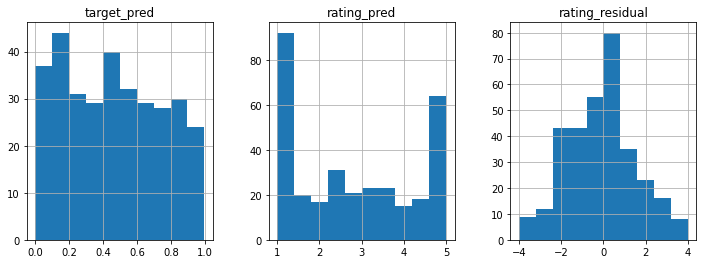

In [22]:
# distribution of residuals
df_res[['target_pred', 'rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()